<h2><big><center>Master M2 MVA 2019/2020 - Graphical models</center></big></h2>
<h3><big><center>Homework 2</center></big></h3>

**STUDENTS**:  AL HOUCINE KILANI - SALMANE NAOUMI

**EMAILS**:  al_houceine.kilani@ens-paris-saclay.fr - salmane.naoumi@ens-paris-saclay.fr

In [44]:
import matplotlib.pyplot as plt
import numpy as np 
import networkx as nx
import timeit
import warnings
import matplotlib.cbook
from utils import *
from Inference import *
from sklearn import datasets
import seaborn as sns
import itertools
import igraph as ig
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib as mpl
from scipy.stats import multivariate_normal
from sklearn.model_selection import cross_val_score

def make_matrix(rows, cols):
    n = rows*cols
    M = np.zeros((n,n))
    for r in range(0, rows):
        for c in range(0, cols):
            i = r*cols + c
            # Two inner diagonals
            if c > 0: M[i-1,i] = M[i,i-1] = 1
            # Two outer diagonals
            if r > 0: M[i-cols,i] = M[i,i-cols] = 1
    return M

def plot_covariances(algorithm, ax, f1, f2, color, diag=False):
    if not diag :
        covariances = algorithm.covariances_[n][[f1,f2],:][:,[f1,f2]]
    else :
        covariances = np.diag(algorithm.covariances_[n])[[f1,f2],:][:,[f1,f2]]
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(algorithm.means_[n,[f1,f2]], v[0], v[1], 180 + angle, color=color)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)
    ax.set_aspect('equal', 'datalim')   

<h3 style="color:blue;"><big>Part 1 : Classification: K-means, and the EM algorithm</big></h3>


In [13]:
iris = datasets.load_iris()
X = iris.data  # we only take the first two features.
y = iris.target
n = X.shape[1]
pair_plots = list(itertools.combinations(range(n), 2))
features = iris.feature_names

**K-means**

Clustering with K-means , accuracy = 0.89


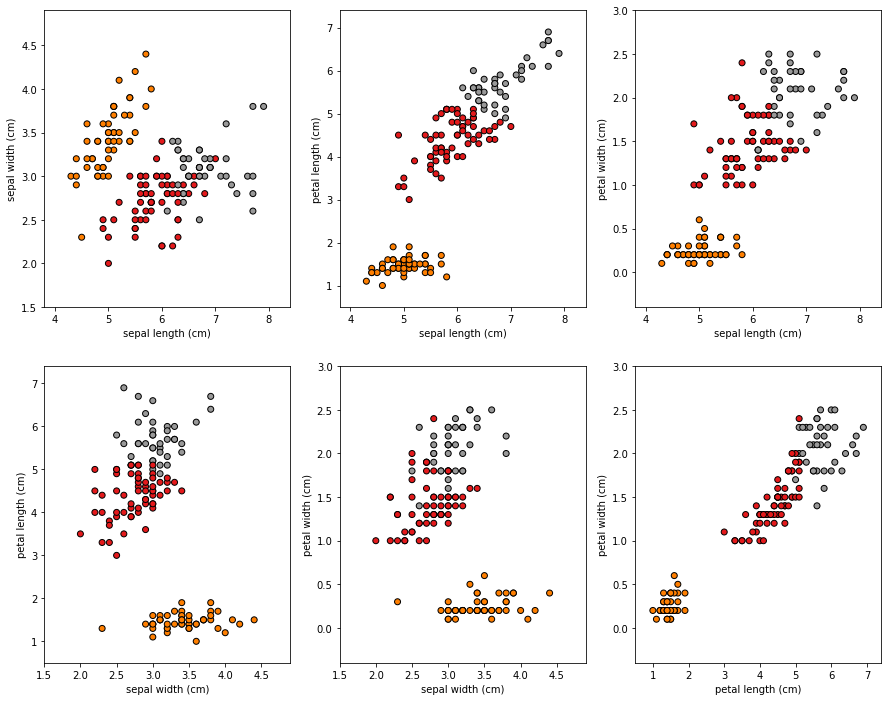

In [14]:
algorithm = KMeans(n_clusters=3, random_state=0)
algorithm.fit(X)
idx = np.argsort(algorithm.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(3)
accuracy = (lut[algorithm.labels_] == y ).mean()

print("Clustering with K-means , accuracy = {:.2f}".format(accuracy))
plt.figure(figsize=(15, 12))
for index, (f1,f2) in enumerate(pair_plots) :
    ax = plt.subplot(2 ,3, index+1)
    x_min, x_max = X[:, f1].min() - .5, X[:, f1].max() + .5
    y_min, y_max = X[:, f2].min() - .5, X[:, f2].max() + .5
    
    # Plot the training points
    
    ax.scatter(X[:, f1], X[:, f2], c= algorithm.labels_ ,cmap=plt.cm.Set1, edgecolor='k')
    ax.set_xlabel(features[f1])
    ax.set_ylabel(features[f2])
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
plt.show();

**GaussianMixture (Full Matrix)**

Clustering with GaussianMixture Full Covariance Matrix , accuracy = 0.97


C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


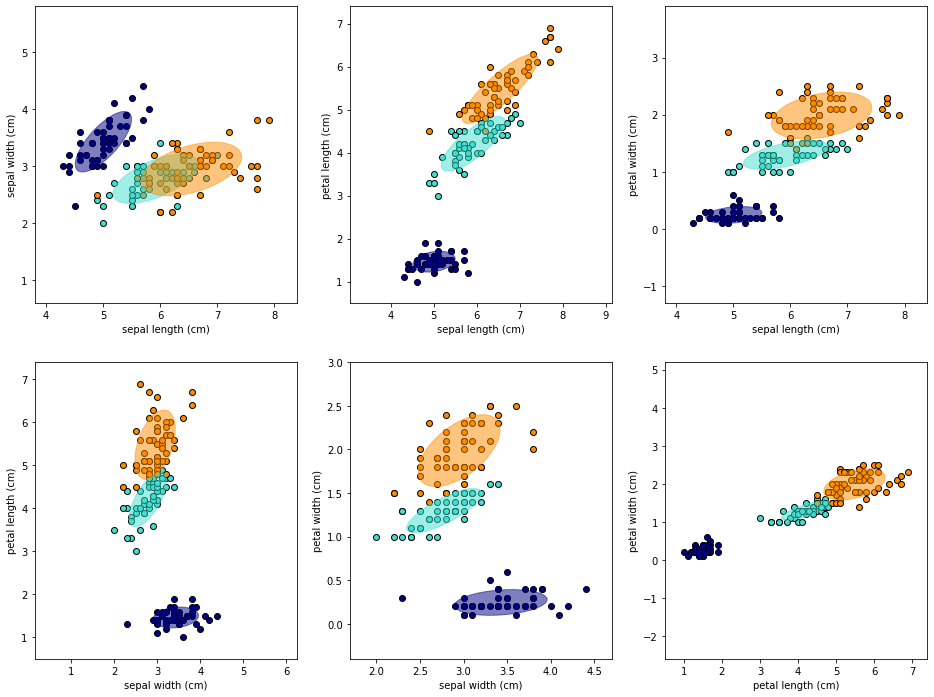

In [15]:
colors = ['navy', 'turquoise', 'darkorange']
algorithm = GaussianMixture(n_components=3, covariance_type='full')
algorithm.fit(X)
labels = algorithm.predict(X)
accuracy = (y == labels).mean()
print("Clustering with GaussianMixture Full Covariance Matrix , accuracy = {:.2f}".format(accuracy))
plt.figure(figsize=(16,12))
ax = plt.subplot(2 ,3, index+1)
for index, (f1,f2) in enumerate(pair_plots) :
    ax = plt.subplot(2 ,3, index+1)
    x_min, x_max = X[:, f1].min() - .5, X[:, f1].max() + .5
    y_min, y_max = X[:, f2].min() - .5, X[:, f2].max() + .5
    for n, color in enumerate(colors):
        plot_covariances(algorithm, ax, f1, f2, color)
        ax.scatter(X[labels==n][:, f1], X[labels==n][:, f2], color=color, cmap=plt.cm.Set1, edgecolor='k')
    ax.set_xlabel(features[f1])
    ax.set_ylabel(features[f2])
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
plt.show();

**GaussianMixture (Diagonal Matrix)**

In [16]:
class DiagonalGaussianMixture:
    
    def __init__(self, n_components, max_iter=5, random_state=0):
        self.n_components = n_components
        self.max_iter = max_iter
        self.random_state = random_state
        self.fitted = False
    def _e_step(self, X):
        
        probabilities = np.vstack([multivariate_normal.pdf(X, mean = self.means_[i] , 
                                                 cov= self.covariances_[i]) for i in range(self.n_components)]).T
        e_step_matrix = self.weights_ * probabilities
        e_step_matrix /= e_step_matrix.sum(axis=1)[:,None]
        
        return e_step_matrix
    
    def _m_step(self, X, e_step_matrix):
        
        self.weights_ = np.sum(e_step_matrix, axis=0) / self.n_samples
        self.means_ = (e_step_matrix.T @ X) / np.sum(e_step_matrix, axis=0)[:,None]
#         self.covariances_ = np.array([(np.sum([e_step_matrix[i,j] * (X[i] - self.means_[j])[:,None] @ \
#                         (X[i] - self.means_[j])[:,None].T for i in range(self.n_samples)], axis=0)/(self.d*e_step_matrix[:,j].sum()))\
#                         for j in range(self.n_components)]) 
#         self.covariances_ = np.array([(np.sum([e_step_matrix[i,j] * (X[i] - self.means_[j])[:,None] @ \
#                                 (X[i] - self.means_[j])[:,None].T for i in range(self.n_samples)], axis=0)/(e_step_matrix[:,j].sum()))\
#                                 for j in range(self.n_components)]) 
        self.covariances_ = np.array([(np.sum([e_step_matrix[i,j] * np.diag((X[i] - self.means_[j])**2) for i in range(self.n_samples)], axis=0)/(e_step_matrix[:,j].sum()))\
                                for j in range(self.n_components)]) 
#         for j in range(self.n_components):
#             self.covariances_[j] = np.diag(self.covariances_[j].diagonal())
            
            
    def fit(self, X):
        '''
        Fits a Gaussian Mixture Model with diagonal covariance matrix to the data
        '''
        self.n_samples, self.d = X.shape
        # Initializing attributes with Kmeans algorithm
        k_means_labels =  KMeans(n_clusters=self.n_components, random_state=self.random_state).fit(X).labels_
        self.weights_ = np.array([np.mean([k_means_labels==i]) for i in range(self.n_components)])
        self.means_ = np.array([np.mean(X[k_means_labels == i], axis=0) for i in range(self.n_components)])
        self.covariances_ = np.array([np.diag(np.std(X[k_means_labels == i], axis=0)) for i in range(self.n_components)])
        # EM algorithm
        for n_iter in range(1, self.max_iter + 1):
            e_step_matrix = self._e_step(X)
            self._m_step(X, e_step_matrix)
        self.fitted = True
            
    def predict(self, X):
        '''
        Predict cluster assignement for data points
        '''
        assert self.fitted == True
        
        # TODO
        w_probabilities =  self.weights_ * np.vstack([multivariate_normal.pdf(X, mean = self.means_[i] , 
                                                       cov= self.covariances_[i]) for i in range(self.n_components)]).T
        
        labels = w_probabilities.argmax(axis=1)
        
        return labels

Clustering with GaussianMixture Diagonal Covariance Matrix , accuracy = 0.90


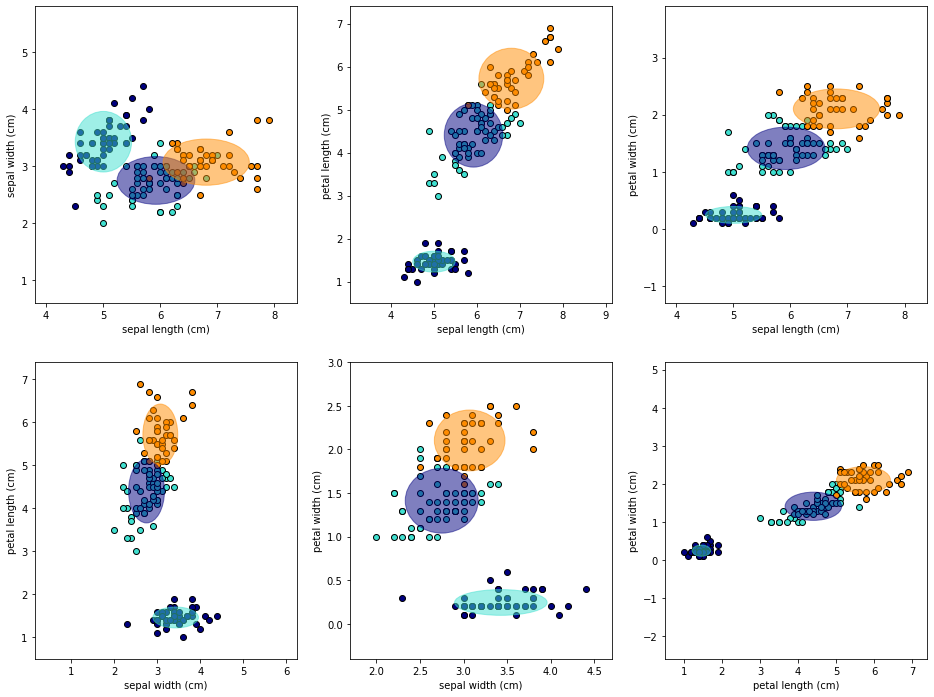

In [20]:
colors = ['navy', 'turquoise', 'darkorange']
algorithm = DiagonalGaussianMixture(n_components=3)
algorithm.fit(X)
labels = algorithm.predict(X)
idx0, idx1 = np.where(labels==0)[0], np.where(labels==1)[0]
labels[idx0] = 1
labels[idx1] = 0
accuracy = (y == labels).mean()
print("Clustering with GaussianMixture Diagonal Covariance Matrix , accuracy = {:.2f}".format(accuracy))
plt.figure(figsize=(16,12))
for index, (f1,f2) in enumerate(pair_plots) :
    ax = plt.subplot(2 ,3, index+1)
    x_min, x_max = X[:, f1].min() - .5, X[:, f1].max() + .5
    y_min, y_max = X[:, f2].min() - .5, X[:, f2].max() + .5
    for n, color in enumerate(colors):
        plot_covariances(algorithm, ax, f1, f2, color)
        ax.scatter(X[labels==n][:, f1], X[labels==n][:, f2], color=color, edgecolor='k')
    ax.set_xlabel(features[f1])
    ax.set_ylabel(features[f2])
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
plt.show();

**GaussianMixture(Diagonal Matrix >> SKlearn version)**

Clustering with GaussianMixture Diagonal Covariance Matrix , accuracy = 0.24


C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


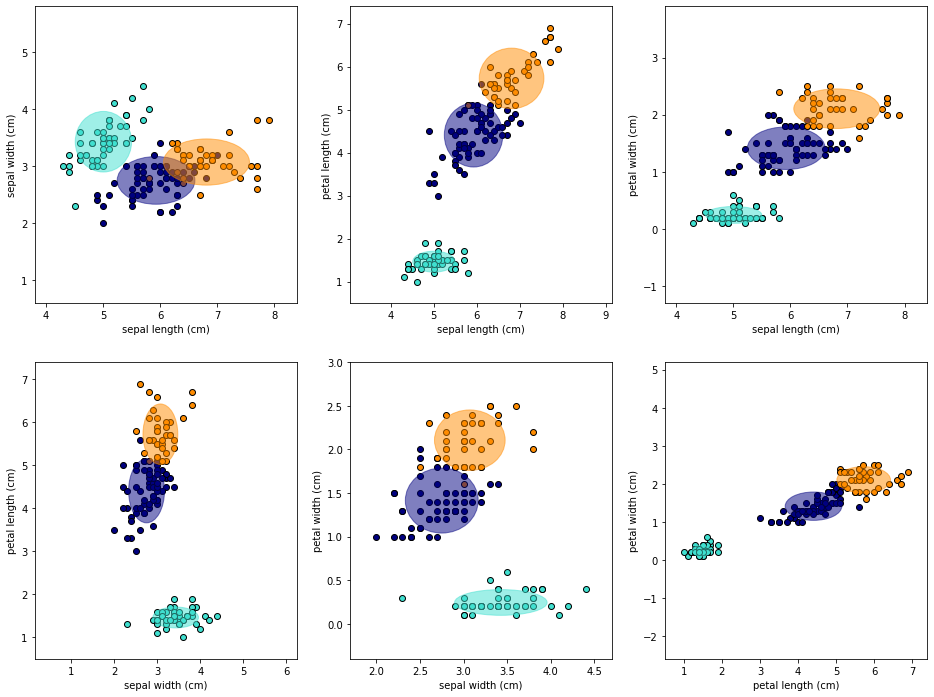

In [18]:
colors = ['navy', 'turquoise', 'darkorange']
algorithm = GaussianMixture(n_components=3, covariance_type='diag')
algorithm.fit(X)
labels = algorithm.predict(X)
accuracy = (y == labels).mean()
print("Clustering with GaussianMixture Diagonal Covariance Matrix , accuracy = {:.2f}".format(accuracy))
plt.figure(figsize=(16,12))
ax = plt.subplot(2 ,3, index+1)
for index, (f1,f2) in enumerate(pair_plots) :
    ax = plt.subplot(2 ,3, index+1)
    x_min, x_max = X[:, f1].min() - .5, X[:, f1].max() + .5
    y_min, y_max = X[:, f2].min() - .5, X[:, f2].max() + .5
    for n, color in enumerate(colors):
        plot_covariances(algorithm, ax, f1, f2, color, diag = True)
        ax.scatter(X[labels==n][:, f1], X[labels==n][:, f2], color=color, cmap=plt.cm.Set1, edgecolor='k')
    ax.set_xlabel(features[f1])
    ax.set_ylabel(features[f2])
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
plt.show();

**Blobs**

Clustering with GaussianMixture Full Covariance Matrix , accuracy = 0.92


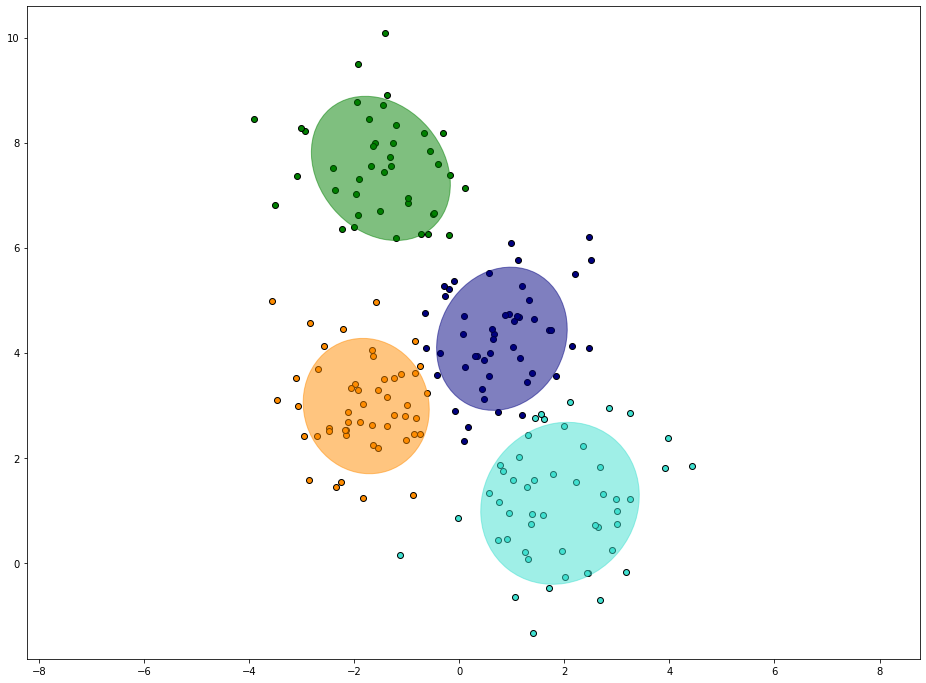

In [546]:
X, y = datasets.make_blobs(n_samples=[50, 44, 57, 39], centers=None,  n_features=2, random_state=0)
colors = ['navy', 'turquoise', 'darkorange', 'green']
algorithm = GaussianMixture(n_components=4, covariance_type='full')
algorithm.fit(X)
labels = algorithm.predict(X)
accuracy = (y == labels).mean()
print("Clustering with GaussianMixture Full Covariance Matrix , accuracy = {:.2f}".format(accuracy))
plt.figure(figsize=(16,12))
ax = plt.subplot(111)
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
for n, color in enumerate(colors):
    covariances = algorithm.covariances_[n][[0,1],:][:,[0,1]]
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(algorithm.means_[n,[0,1]], v[0], v[1], 180 + angle, color=color)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)
    ax.set_aspect('equal', 'datalim')  
    ax.scatter(X[labels==n][:, 0], X[labels==n][:, 1], color=color, cmap=plt.cm.Set1, edgecolor='k')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plt.show();

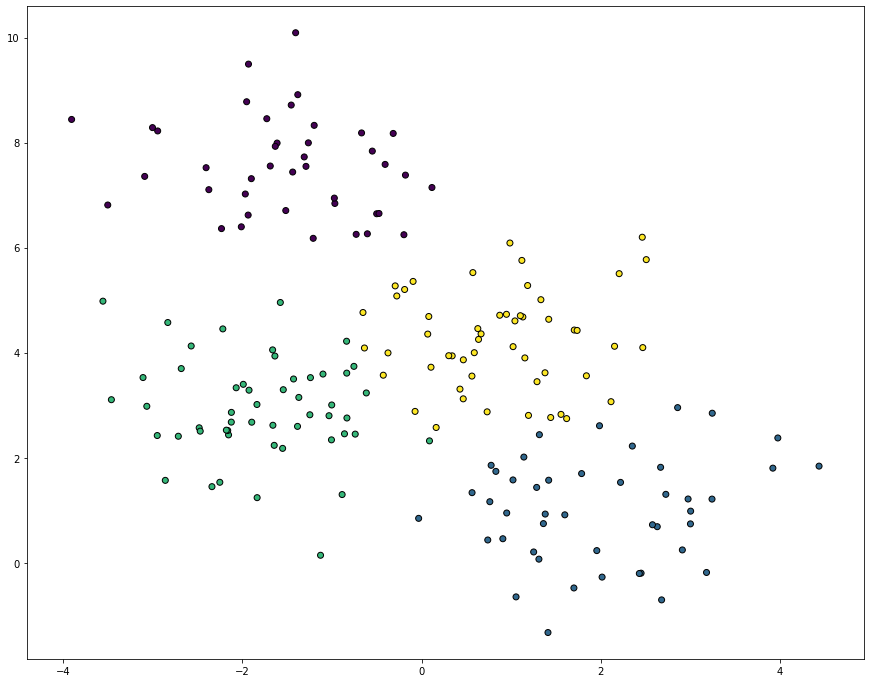

In [561]:
algorithm = KMeans(n_clusters=4, random_state=0)
algorithm.fit(X)

accuracy = (algorithm.labels_== y ).mean()

# print("Clustering with K-means , accuracy = {:.2f}".format(accuracy))
plt.figure(figsize=(15, 12))
ax = plt.subplot(111)
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

# Plot the training points

ax.scatter(X[:, 0], X[:, 1], c= algorithm.labels_ , edgecolor='k')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plt.show();

<h3 style="color:blue;"><big>Part 2 : Graphs, algorithms and Ising</big></h3>


**The sum-product algorithm**  :  
- Supposing that the random variables of the chain can only take K values, the factors $\psi_{i,i+1}$ are matrices of shape (K,K). And the $\psi_i$ have a shape (K,1)
- We are not going to bother about the normalization of the messages.
- The forward messages of the leaves are initialized to a column vector of ones 

In [2]:
def chain(N, K):
    
    list_phi_i = np.zeros((N,K))
    for i in range(N):
        list_phi_i[i] = np.random.rand(K)
    
    list_phi_i_j = np.zeros((N-1,K,K))
    for i in range(N-1):
        list_phi_i_j[i] = np.random.rand(K,K)
        
    return list_phi_i, list_phi_i_j

def sum_product_chain(factors_i, factors_i_j):
    
    num_edges, num_state = factors_i_j.shape[0:2]
    messages = dict()
    messages["forward"] = np.zeros((num_edges,num_state, 1))        
    messages["backward"] = np.zeros((num_edges,num_state, 1))
    
    # iniatilization of the messages of the leaves

    messages["forward"][0] = factors_i_j[0] @ (factors_i[0] * np.ones(num_state))[:,None]
    messages["backward"][-1] = factors_i_j[-1] @ (factors_i[-1] *np.ones(num_state))[:,None]

    
    for i in range(num_edges -1 ) :
        messages["forward"][i+1] = factors_i_j[i+1] @ (np.exp(np.log(factors_i[i][:,None]) + np.log(messages["forward"][i])))
#     for i in range(num_edges):
#         messages["forward"][i] = messages["forward"][i]/ messages["forward"][i].sum()
        
    for i in range(num_edges-2,- 1,-1):
        messages["backward"][i] = factors_i_j[i] @ (np.exp(np.log(factors_i[i+1][:,None]) + np.log(messages["backward"][i+1])))
#     for i in range(num_edges):
#         messages["backward"][i] = messages["backward"][i]/ messages["backward"][i].sum()

    return messages

In [3]:
factors_i, factors_i_j = chain(5,2)
sum_product_chain(factors_i, factors_i_j)

{'forward': array([[[0.62809817],
         [0.10729063]],
 
        [[0.47721345],
         [0.24527155]],
 
        [[0.103334  ],
         [0.16801009]],
 
        [[0.03577051],
         [0.04773278]]]), 'backward': array([[[0.09975746],
         [0.01056414]],
 
        [[0.23130623],
         [0.15531964]],
 
        [[0.16712841],
         [0.25831303]],
 
        [[0.19122712],
         [0.25764562]]])}

**The Ising model**: 

In [21]:
def number_equal_neighbors(L):
    
    return np.count_nonzero(np.diff(L)==0)

def factors_i_func(h, w, beta) : 
    
    states = np.array(list(itertools.product([0, 1], repeat=w)))
    factors_i = np.apply_along_axis(number_equal_neighbors, 1, states)
#     factors_i = factors_i/factors_i.sum()
    factors_i = np.tile(np.exp(beta * factors_i), (h-1,1))
    
    factors_i_j = np.zeros((2**w, 2**w))
    np.fill_diagonal(factors_i_j, w)
    for i in range(len(states)):
        for j in range(i+1, len(states)):
            count = np.count_nonzero((states[i] - states[j])==0)
            factors_i_j[i][j] = count
            factors_i_j[j][i] = count
#     factors_i_j= factors_i_j/factors_i_j.sum(axis=1)
        
    factors_i_j = np.exp(beta * factors_i_j)
    factors_i_j = np.tile(factors_i_j, (h-1,1,1))
    
    return factors_i, factors_i_j


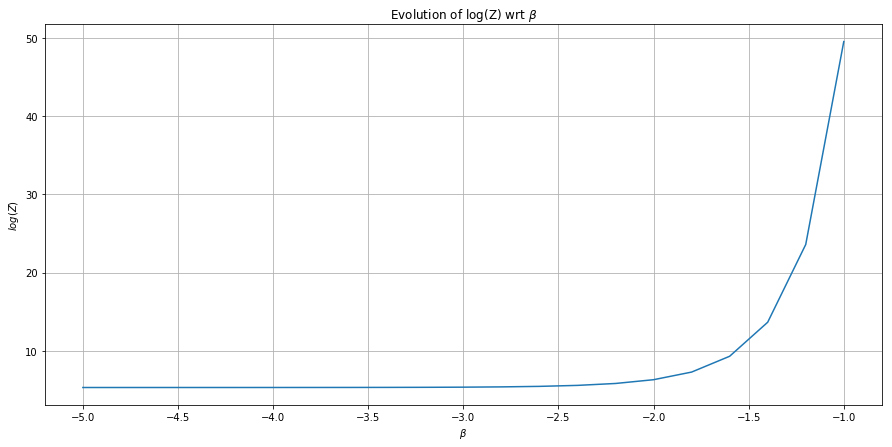

In [22]:
list_beta = np.linspace(-5,-1,21)
list_Z = np.zeros(len(list_beta))
ind = 0
for beta in list_beta :
    factors_i, factors_i_j = factors_i_func(100,10, beta)
    messages = sum_product_chain(factors_i, factors_i_j)
    Z = np.array([0])
    for i in range(len(factors_i)) :
        Z= np.add(Z,factors_i[i] @ (messages["forward"][i] * messages["backward"][i]))
        
    list_Z[ind] = Z
    ind+=1
    
plt.figure(figsize = (15,7))
plt.grid()
plt.title(r"Evolution of log(Z) wrt $\beta$")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$log(Z)$")
plt.plot(list_beta, np.log(list_Z));

**Loopy belief propagation**: 

In [72]:
class LBPInference(Inference):
    """
    implements sum-product loopy belief propagation inference 
    for  p(x) \propto exp(+\sum_{i,j<i} x_i x_j adj[i,j] + \sum_{i} x_i adj[i,i]) for  x_i \in {-1,+1}
    """
    def __init__(self,
                 adj,
                 beta,
                 alpha=0, 
                 verbosity=0,
                 max_iters=1000,  # max number of iterations
                 damping=.1,  # damping=0 means no damping
                 eps=1e-16,  # threshold for convergence
    ):
        Inference.__init__(self, adj, verbosity=verbosity)
        self.damping = damping
        self.max_iters = max_iters
        # (i,j)th element is the log-ratio of message i->j
        self.msg_new = None
        self.msg_old = None
        self.marginals = None
        self.converged = False
        self.mask = None  # zero-one mask for the adjacency (zero diagonals)
        self.eps = eps
        self._initialize()
        self.adj = adj
        self.beta = beta
        self.alpha = alpha

    def update_adjacency(self, new_adj):
        self.adj = new_adj
        self._initialize()

    def _initialize(self):
        n = self.adj.shape[0]
        self.msg_new = np.zeros((n , n))
        self.msg_old = np.zeros((n , n))
        self.marginals = np.zeros(n)
        mask = (self.adj != 0)
        np.fill_diagonal(mask, 0)
        self.mask = mask
        self.converged = False

    def _apply_damping(self, msg_new, msg_old):
        #convert to probability
        msg_new_p = logistic(msg_new)
        msg_old_p = logistic(msg_old)
        msg_p = msg_old_p * (self.damping) + msg_new_p * (1. - self.damping)
        # convert back to log-ratio
        msg = np.log(msg_p) - np.log(1. - msg_p)
        return msg
    
    def _inference(self):
        if self._verbosity > 0:
            print("running BP", flush = True)
        t = 0
        while t < self.max_iters:
            self.msg_old = self.msg_new.copy()
            for i in range(0, n):
                for j in range(0, n):
                    if self.mask[i,j] != 0:
                        neighbours = self.mask[i].copy()

                        neighbours[j] = 0
                        num = np.logaddexp((self.adj[i][i] + self.adj[i][j] + \
                        np.sum(self.msg_old[:,i][neighbours])), (-self.adj[i][i] - self.adj[i][j]))                   
                        den = np.logaddexp((self.adj[i][i] - self.adj[i][j] + \
                        np.sum(self.msg_old[:,i][neighbours])), (-self.adj[i][i] + self.adj[i][j]))
                        self.msg_new[i][j] = num - den
            t += 1
            if np.amax(np.absolute(self.msg_new - self.msg_old)) < self.eps:
                break
        
        new_marginals = np.sum(self.msg_new, 0) + np.diagonal(self.adj)*2
        self.marginals = new_marginals
        if self._verbosity > 0:
            print("finished after {} iterations!".format(t), flush = True)
    def get_marginal(self, target):
        if not self.converged:
            self._inference()
            self.converged = True
        mrg = logistic(self.marginals)[target]
        return mrg

**Fhad l'implémentation dayrino bla alpha o beta**

In [73]:
width, height = 10, 100
grid_2d_graph = make_matrix(width, height)

margs = LBPInference(grid_2d_graph, beta = 1)
marginals = margs.get_marginal(list(range(grid_2d_graph.shape[0])))
marginals

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.

Hada ki 3ti l7ssab mazyan 

In [74]:
true_margs = CliqueTreeInference(adj).get_marginal(list(range(adj.shape[0])))  
true_margs

array([3.82170740e-01, 5.04614579e-01, 9.27716075e-01, 2.08644237e-03,
       5.98865377e-02, 3.99468555e-02, 9.80420759e-01, 8.48612844e-01,
       2.15927378e-05, 1.90368943e-02, 7.00279019e-04, 9.25233719e-04,
       2.57109069e-01, 6.86188587e-01, 5.30334606e-02, 4.32046774e-04,
       1.90243810e-01, 6.98614692e-01, 1.38997135e-01, 9.15133134e-01,
       2.25061544e-03, 5.70967896e-05, 9.94719012e-01, 7.55847901e-01,
       1.88333026e-01, 2.80028679e-04, 9.99994675e-01, 9.50905447e-02,
       4.03783700e-01, 9.99800900e-01, 9.99980483e-01, 9.93120193e-01,
       9.08142673e-01, 3.52052280e-01, 1.23808481e-03, 8.37546875e-01,
       9.63596003e-01, 2.07818987e-01, 5.18662365e-01, 9.28713027e-01,
       9.10719781e-01, 8.58108421e-01, 8.25261150e-01, 1.81896700e-01,
       1.04611799e-01, 7.20417134e-03, 9.98094449e-01, 9.04964445e-01,
       5.77956690e-02, 1.42137728e-01, 8.20313737e-01, 2.08855659e-01,
       6.77555218e-01, 3.50179214e-03, 5.06472808e-01, 3.08424520e-01,
      